# Few-shot Learning기반 얼굴 유사도 평가해보기

1. ORL face 데이터셋 살펴보기
2. Few-shot learning을 위한 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기
3. Siamese network 아키텍처 소개와 구현해보기
4. Contrastive loss function 설명 및 구현해보기
5. Face recognition을 위한 학습코드 작성해보기
6. 학습한 모델로 유사도 평가해보기

In [1]:
import os
from pathlib import Path

In [2]:
data_dir = "D:/SECURITY-DATASET/Face-Recognition/"
phase = "train"

In [3]:
person_items = []

In [4]:
for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    if len(files) > 0:
        for file_name in files:
            person_items.append(os.path.join(root, file_name))

In [5]:
person_items[4]

'D:/SECURITY-DATASET/Face-Recognition/train\\s1\\4.png'

In [6]:
len(person_items)

70

In [7]:
index = 0
faceA_path = person_items[index]

In [8]:
faceA_path

'D:/SECURITY-DATASET/Face-Recognition/train\\s1\\1.png'

In [9]:
Path(faceA_path).parent

WindowsPath('D:/SECURITY-DATASET/Face-Recognition/train/s1')

In [10]:
#부모 directory 추출
Path(faceA_path).parent.name

's1'

In [11]:
person = Path(faceA_path).parent.name

In [12]:
person

's1'

In [13]:
same_person_dir = Path(faceA_path).parent

In [14]:
[fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

['1.png',
 '10.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png']

In [15]:
same_person_images = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

In [16]:
same_person_images

['1.png',
 '10.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png']

In [17]:
import numpy as np

In [18]:
np.random.choice(same_person_images)

'5.png'

In [19]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_images))

In [20]:
faceB_path

'D:\\SECURITY-DATASET\\Face-Recognition\\train\\s1\\8.png'

In [21]:
import cv2
import matplotlib.pyplot as plt

In [22]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

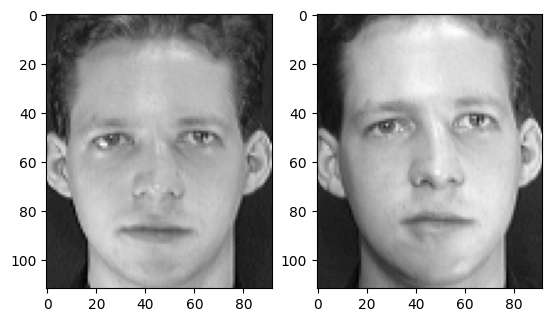

In [23]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

In [24]:
person

's1'

In [25]:
while True:
    faceB_path = np.random.choice(person_items)
    if person != Path(faceB_path).parent.name:
        break

In [26]:
faceB_path

'D:/SECURITY-DATASET/Face-Recognition/train\\s10\\3.png'

In [27]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

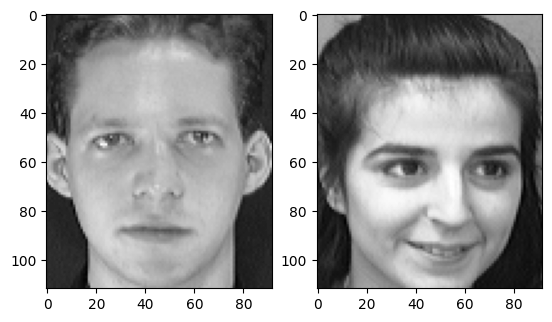

In [28]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

# Few-shot learning을 위한 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [32]:
class Face_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.person_items)

    def __getitem__(self, index):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name

        same_person = np.random.randint(2)
        
        if same_person:
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))
        else:
            while True:
                faceB_path = np.random.choice(self.person_items)
                if person != Path(faceB_path).parent.name:
                    break
        
        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)

        if self.transformer:
            faceA_image = self.transformer(faceA_image)
            faceB_image = self.transformer(faceB_image)

        return faceA_image, faceB_image, np.array([1-same_person])

# 동일인물일때 (positive sampling) -> label/target : 0
# 다른인물일때 (negative sampling) -> label/target : 1

In [34]:
data_dir = "D:/SECURITY-DATASET/Face-Recognition/"
trn_ds = Face_Dataset(data_dir, phase="train")

In [35]:
index = 0
faceA, faceB, other = trn_ds[index]

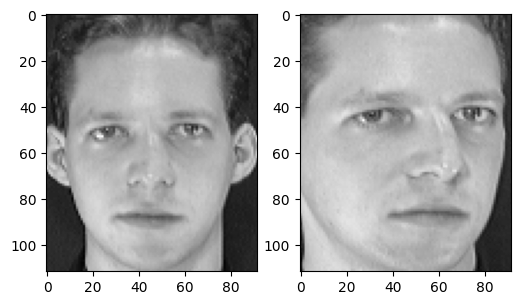

[0]


In [36]:
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
plt.show()
print(other)

In [37]:
from ipywidgets import interact

In [38]:
@interact(index=(0, len(trn_ds)-1))
def show_sample(index=0):
    faceA, faceB, other = trn_ds[index]
    plt.figure(figsize=(6, 6))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    plt.show()
    print(other)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [39]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [40]:
def build_transformer(image_size=100):
    transformers = {}
    transformers["train"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
    
    transformers["val"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
    return transformers

In [41]:
IMAGE_SIZE = 100
transformers = build_transformer(image_size=IMAGE_SIZE)

In [42]:
train_dataset = Face_Dataset(data_dir=data_dir, phase="train", transformer=transformers["train"])
val_dataset = Face_Dataset(data_dir=data_dir, phase="val", transformer=transformers["val"])

In [43]:
train_dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.8902, -0.8745,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]]),
 tensor([[[-0.6000, -0.5843, -0.6157,  ..., -0.6627, -0.6314, -0.6078],
          [-0.6078, -0.5922, -0.6235,  ..., -0.6706, -0.6706, -0.6314],
          [-0.6078, -0.6000, -0.6549,  ..., -0.6863, -0.7176, -0.6863],
          ...,
          [-1.0000, -1.0000, -0.6941,  ..., -0.6235, -0.6000, -0.6235],
          [-1.0000, -1.0000, -0.6941,  ..., -0.6314, -0.5922, -0.6078],
          [-1.0000, -1.0000, -0.7176,  ..., -0.6235, -0.6078, -0.6000]]]),
 array([0]))

In [44]:
val_dataset[0][0].shape

torch.Size([1, 100, 100])

In [45]:
tr_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=64)

In [46]:
def build_dataloader(data_dir, batch_size=64):
    dataloaders = {}
    
    transformers = build_transformer()
    train_dataset = Face_Dataset(data_dir=data_dir, phase="train", transformer=transformers["train"])
    val_dataset = Face_Dataset(data_dir=data_dir, phase="val", transformer=transformers["val"])
    
    dataloaders["train"] = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    dataloaders["val"] = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
    return dataloaders

In [47]:
data_dir = "/jf-training-home/datasets_rw/Face-Recognition/"
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
dataloaders

In [ ]:
for _ in range(3):
    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            faceAs = batch[0]
            faceBs = batch[1]
            others = batch[2]
            
            if index % 100 == 0:
                print(f"{phase} - {index}/{len(dataloaders[phase])}")

# 3. Siamese Network 아키텍처 소개와 구현해보기

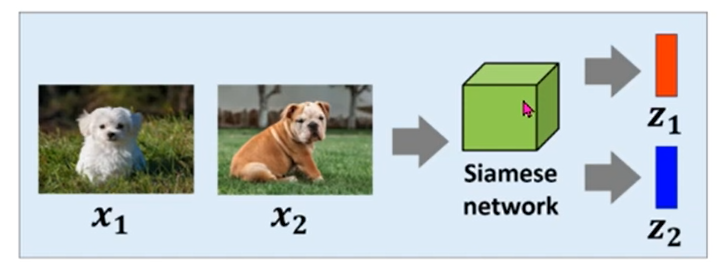

In [48]:
import torch
from torch import nn

In [49]:
def ConvBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
    )

In [50]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        
        self.features = nn.Sequential(
            ConvBlock(input_channel, 4),
            ConvBlock(4, 8),
            ConvBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )
    
    def forward(self, x1, x2):
        z1 = self.features(x1)
        z2 = self.features(x2)
        return z1, z2

In [51]:
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)

model = SiameseNetwork(input_channel=1)

z1, z2 = model(x1, x2)

In [52]:
print(z1.shape, z2.shape)

torch.Size([1, 10]) torch.Size([1, 10])


In [53]:
z1

tensor([[ 0.0078, -0.0340, -0.0298,  0.0274,  0.0676,  0.0175,  0.1125, -0.0131,
          0.0193,  0.1708]], grad_fn=<AddmmBackward0>)

In [54]:
z2

tensor([[-0.1071, -0.0650,  0.1228, -0.1177, -0.0859,  0.0327,  0.1113,  0.0169,
          0.0190, -0.0245]], grad_fn=<AddmmBackward0>)

# 4. Contrastive loss function 설명 및 구현해보기
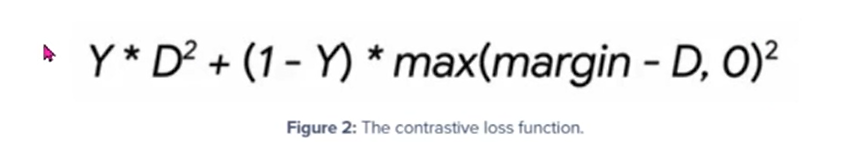

- D^2(거리 제곱)의 거리를 줄이는 방향으로 학습
- 가까운 것은 더 가까이 먼 것은 더 멀리



출처 : https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/

In [55]:
"""
Label
same perspon -> 0 
other person -> 1
"""

'\nLabel\nsame perspon -> 0 \nother person -> 1\n'

In [56]:
import torch.nn.functional as F

In [57]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        
    def forward(self, z1, z2, label):
        dist = F.pairwise_distance(z1, z2, keepdim=True) # 두 vector 간의 distance를 계산 해줌
        loss = torch.mean((1-label) * torch.pow(dist,2) + label * torch.pow(torch.clamp((self.margin - dist), min=0), 2))
        acc = ((dist > 0.6) == label).float().mean()
        return loss, acc
        

In [58]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.clamp(self.margin**2 - torch.pow(euclidean_distance, 2), min=0.0))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

# Face Recognition을 위한 학습코드 작성해보기

In [59]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_acc = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            imgA = batch[0].to(device)
            imgB = batch[1].to(device)
            label = batch[2].to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                codeA, codeB = model(imgA, imgB)
            loss, acc = criterion(codeA, codeB, label)
                
            if phase == "train":
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            running_acc += acc.item()
                    
        losses[phase] = running_loss/len(dataloaders[phase])
        accuracies[phase] = running_acc/len(dataloaders[phase])
    return losses, accuracies

In [60]:
def save_model(model_state, model_name):
    save_dir = "./trained_model"
    os.makedirs("./trained_model", exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [66]:
data_dir = "D:/SECURITY-DATASET/Face-Recognition/"
is_cuda = True

IMAGE_SIZE = 100
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = SiameseNetwork(input_channel=1)
model = model.to(DEVICE)
criterion = ContrastiveLoss(margin=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [68]:
num_epochs = 10

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accs = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss.append(losses["train"])
    train_acc.append(accs["train"])
    val_loss.append(losses["val"])
    val_acc.append(accs["val"])
    
    print(f"{epoch}/{num_epochs} - train loss:{losses['train']:.4f}, val loss:{losses['val']:.4f}, train acc:{accs['train']:.4f}, val acc:{accs['val']:.4f}")
    
    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f"model_{epoch+1}.pth")

0/10 - train loss:1.6071, val loss:2.1333, train acc:0.6000, val acc:0.4667
1/10 - train loss:2.4385, val loss:1.8667, train acc:0.3857, val acc:0.5333
2/10 - train loss:2.1125, val loss:1.4667, train acc:0.4714, val acc:0.6333
3/10 - train loss:2.2824, val loss:2.1333, train acc:0.4286, val acc:0.4667
4/10 - train loss:2.2219, val loss:2.0000, train acc:0.4429, val acc:0.5000
5/10 - train loss:2.4323, val loss:1.8666, train acc:0.3857, val acc:0.5333
6/10 - train loss:1.8421, val loss:1.7333, train acc:0.5286, val acc:0.5667
7/10 - train loss:1.8352, val loss:1.2000, train acc:0.5429, val acc:0.7000
8/10 - train loss:2.0374, val loss:1.8666, train acc:0.5000, val acc:0.5333
9/10 - train loss:1.7615, val loss:1.8664, train acc:0.5714, val acc:0.5333


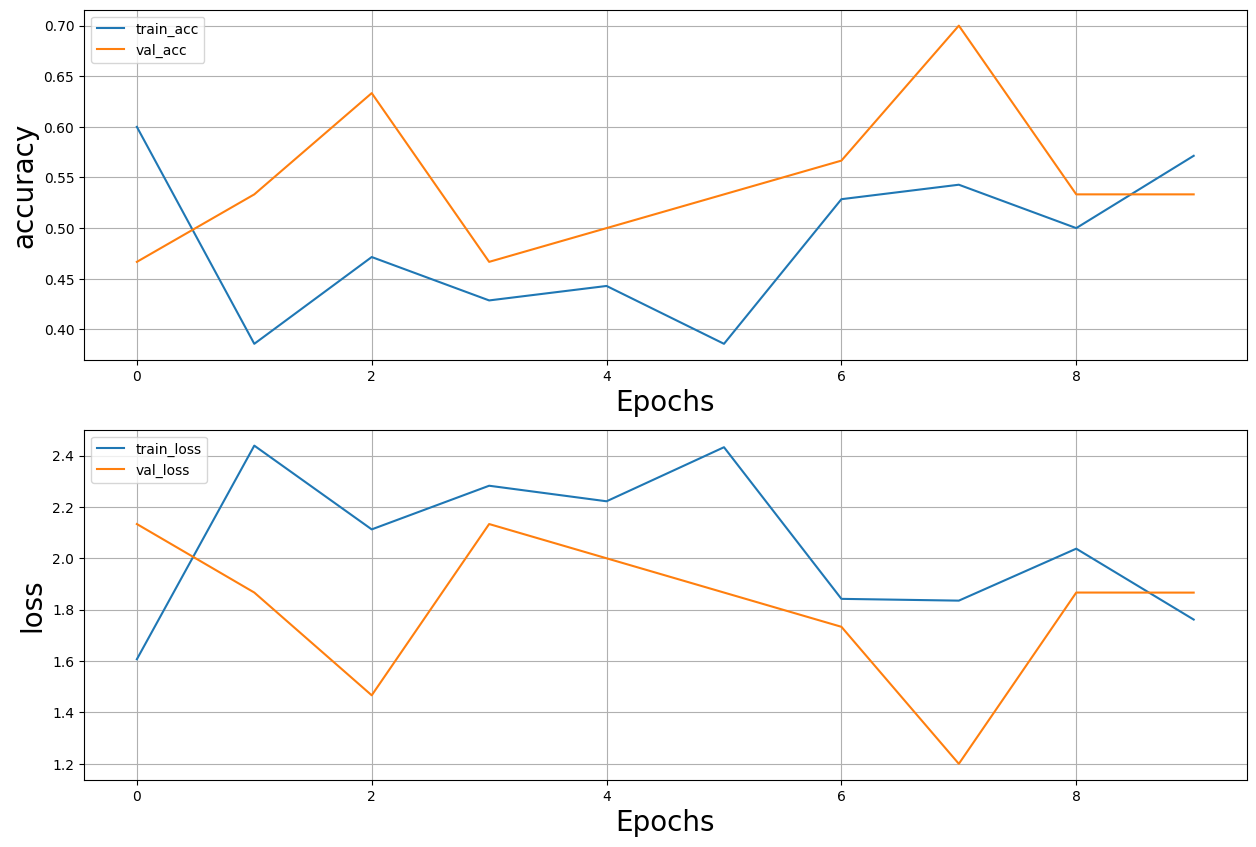

In [70]:
plt.figure(figsize=(15,10))
plt.subplot(212)
plt.plot(range(num_epochs), train_loss, label = "train_loss")
plt.plot(range(num_epochs), val_loss, label = "val_loss")
plt.legend(loc = 'upper left')
plt.xlabel("Epochs", size=20)
plt.ylabel("loss", size=20)
plt.grid(True)

plt.subplot(211)
plt.plot(range(num_epochs), train_acc, label = "train_acc")
plt.plot(range(num_epochs), val_acc, label = "val_acc")
plt.legend(loc = 'upper left')
plt.xlabel("Epochs", size=20)
plt.ylabel("accuracy", size=20)b
plt.grid(True)

# 유클리디언
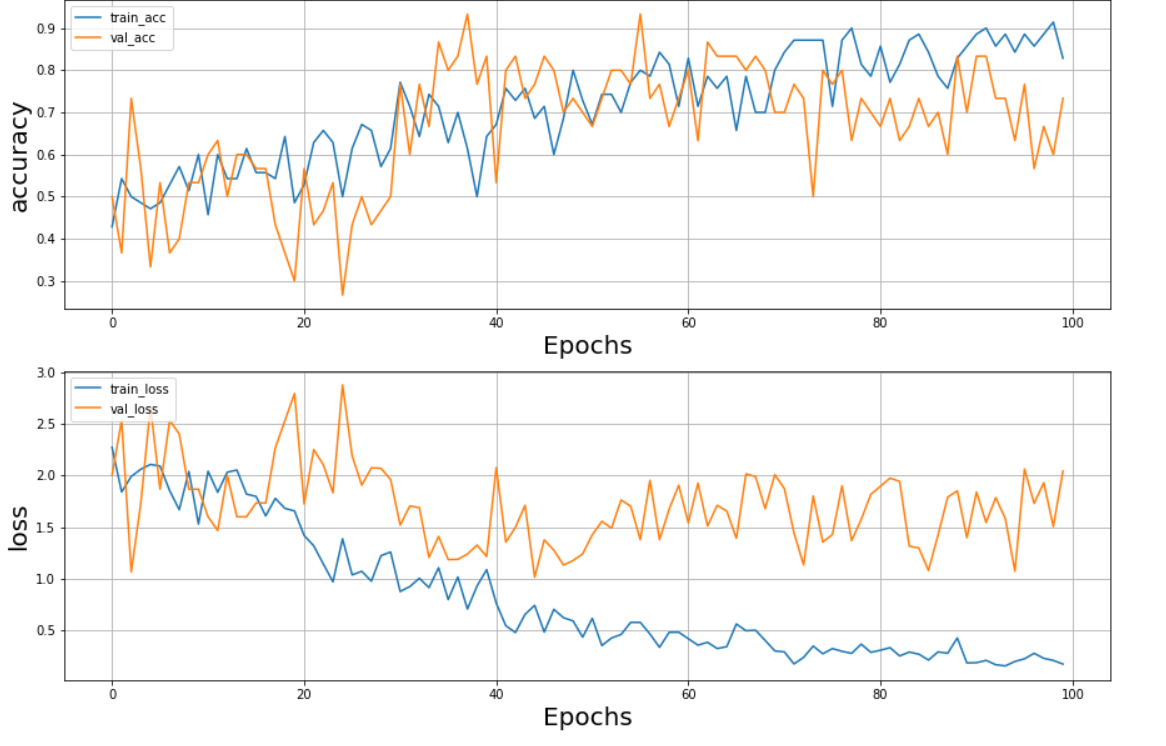

# 기본
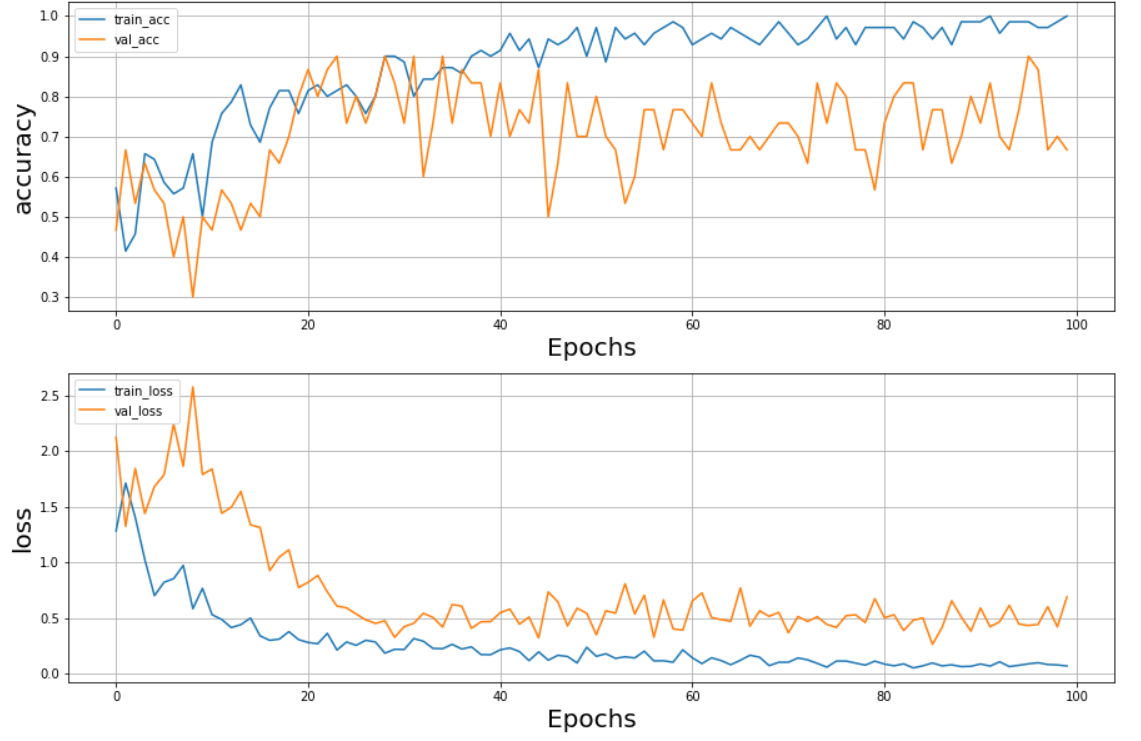

In [81]:
num_epochs = 10

for epoch in range(num_epochs):
    losses, accs = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    
    print(f"{epoch}/{num_epochs} - train loss:{losses['train']:.4f}. val loss:{losses['val']:.4f}. train acc:{accs['train']:.4f}. val acc{accs['val']:.4f}")
    
    if (epoch + 1) % 20 == 0:
          save_model(model.state_dict(), f"model_{epoch+1}.pth")

0/10 - train loss:1.8736. val loss:2.1284. train acc:0.5429. val acc0.4667
1/10 - train loss:2.3370. val loss:2.3928. train acc:0.4571. val acc0.4000
2/10 - train loss:2.0942. val loss:1.6026. train acc:0.4571. val acc0.6000
3/10 - train loss:1.9974. val loss:2.3956. train acc:0.5143. val acc0.4000
4/10 - train loss:2.3578. val loss:2.3932. train acc:0.3857. val acc0.4000
5/10 - train loss:1.8805. val loss:1.9920. train acc:0.5571. val acc0.5000
6/10 - train loss:2.0827. val loss:1.3279. train acc:0.4857. val acc0.6667
7/10 - train loss:2.0755. val loss:2.1264. train acc:0.5000. val acc0.4667
8/10 - train loss:1.9336. val loss:2.1249. train acc:0.5000. val acc0.4667
9/10 - train loss:1.8698. val loss:1.8581. train acc:0.5429. val acc0.5333


# 학습한 모델로 유사도 평가해보기

In [71]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork(input_channel=1)
    model.load_state_dict(checkpoint)
    print(model.load_state_dict(checkpoint))
    model.eval()
    return model.to(device)

In [73]:
ckpt_path = "./trained_model/model_10.pth"
is_cuda = False

IAMGE_SIZE = 100
DEVICE = torch.device('cpu')
model = load_model(ckpt_path, DEVICE)

<All keys matched successfully>


In [74]:
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

In [76]:
@torch.no_grad()
def recognize_face(dataset, index, model, device):
    val_dataset = dataset(data_dir, phase="val")
    faceA, faceB, label = val_dataset[index]
    tensor_faceA = transformer(faceA).to(device) # (C, H, W) / (1, 100, 100)
    tensor_faceB = transformer(faceB).to(device) # (C, H, W) / (1, 100, 100)
    
    codeA, codeB = model(tensor_faceA.unsqueeze(0), tensor_faceB.unsqueeze(0)) # (B, C, H, W) / (1, 1, 100, 100)
    dist = F.pairwise_distance(codeA, codeB)
    
    output = "same person" if dist.item() < 0.6 else "different person"
    return faceA, faceB, dist.item(), output

In [77]:
@interact(index=(0,29))
def show_result(index=0):
    faceA, faceB, dist, output = recognize_face(Face_Dataset, index, model, DEVICE)
    
    plt.figure(figsize=(7,4))
    plt.suptitle(f"{output} - dissimilarity:{dist:.2f}")
    plt.subplot(121)
    plt.imshow(faceA, cmap = "gray")
    plt.subplot(122)
    plt.imshow(faceB, cmap = "gray")

interactive(children=(IntSlider(value=0, description='index', max=29), Output()), _dom_classes=('widget-intera…

# 5. Tensorboard를 활용하여 Latent Vector 시각화 해보기

In [83]:
class Face_Dataset():
    def __init__(self, data_dir, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(data_dir):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))
                    
        self.transformer = transformer
        
    def __len__(self): return len(self.person_items)
    

    def __getitem__(self, index):
        face_path = self.person_items[index]
        face_image = cv2.imread(face_path, 0)
        
        if self.transformer:
            face_image = self.transformer(face_image)
            
        person_name = Path(face_path).parent.name
        return face_image, person_name    

In [84]:
data_dir = "D:/SECURITY-DATASET/Face-Recognition/"
dset = Face_Dataset(data_dir)

In [85]:
len(dset)

100

In [86]:
dset[0]

(array([[48, 49, 45, ..., 56, 56, 54],
        [45, 52, 39, ..., 52, 50, 51],
        [45, 50, 42, ..., 48, 53, 50],
        ...,
        [50, 48, 50, ..., 45, 46, 46],
        [45, 54, 49, ..., 46, 47, 47],
        [51, 51, 51, ..., 47, 46, 46]], dtype=uint8),
 's1')

In [126]:
def build_transformer(image_size = 100):
    transformer = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
  
    return transformer

In [127]:
def convBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
    )

In [128]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1):
        out1 = self.features(x1)
        return out1

In [129]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork()
    model.load_state_dict(checkpoint)
    model.eval()
    return model.to(device)

In [130]:
ckpt_path = "./trained_model/model_10.pth"

is_cuda = False

DEVICE = torch.device("cpu")

transformer = build_transformer(image_size=100)
dataset = Face_Dataset(data_dir, transformer=transformer)
dataloader = DataLoader(dataset, shuffle = False, batch_size = 1)
model = load_model(ckpt_path, DEVICE)

In [131]:
x = torch.randn(1,1,100,100)
model.forward(x)

tensor([[-0.0929,  0.0973,  0.2287, -0.1667,  0.0922,  0.1117,  0.1462, -0.1016,
         -0.0285,  0.0293]], grad_fn=<AddmmBackward0>)

In [132]:
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [133]:
writer = SummaryWriter('runs/face_features')

In [134]:
all_images = []
all_labels = []
all_embeds = []

for index, batch in enumerate(dataloader):
    image = batch[0]
    label = batch[1]
    
    with torch.no_grad():
        embed = model(image.to(DEVICE))
    embed = embed.detach().numpy()
    
    image = make_grid(image, normalize=True).permute(1,2,0) # (C, H, W) -> (H, W, C)
    image = cv2.resize(np.array(image), dsize=(80,80), interpolation=cv2.INTER_NEAREST)
    
    all_images.append(image)
    all_labels.append(label)
    all_embeds.append(embed)
    
all_images = torch.Tensor(np.moveaxis(np.stack(all_images, axis=0), 3, 1))
all_embeds = torch.Tensor(np.stack(all_embeds, axis=0).squeeze(1))
all_labels = np.stack(all_labels, axis=1).squeeze(0)

writer.add_embedding(all_embeds, label_img=all_images, metadata_header=all_labels)


In [135]:
all_labels

array(['s1', 's1', 's1', 's1', 's1', 's1', 's1', 's1', 's1', 's1', 's10',
       's10', 's10', 's10', 's10', 's10', 's10', 's10', 's10', 's10',
       's2', 's2', 's2', 's2', 's2', 's2', 's2', 's2', 's2', 's2', 's3',
       's3', 's3', 's3', 's3', 's3', 's3', 's3', 's3', 's3', 's4', 's4',
       's4', 's4', 's4', 's4', 's4', 's4', 's4', 's4', 's8', 's8', 's8',
       's8', 's8', 's8', 's8', 's8', 's8', 's8', 's9', 's9', 's9', 's9',
       's9', 's9', 's9', 's9', 's9', 's9', 's5', 's5', 's5', 's5', 's5',
       's5', 's5', 's5', 's5', 's5', 's6', 's6', 's6', 's6', 's6', 's6',
       's6', 's6', 's6', 's6', 's7', 's7', 's7', 's7', 's7', 's7', 's7',
       's7', 's7', 's7'], dtype='<U3')